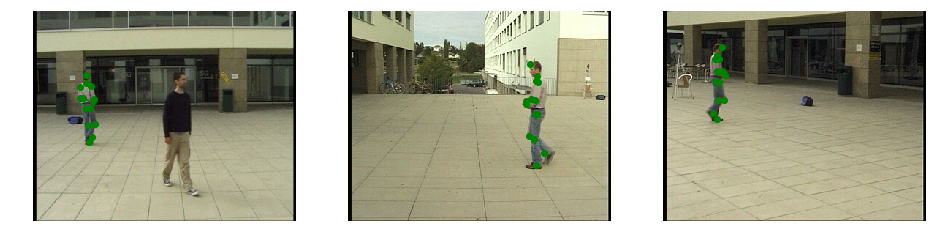

In [1]:
# Evaluation frames: [350 - 470] and [650 - 750].

%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

#[351 352 353 354 355 356 357 358 669 670 671 672 680 690 691 692 693]
#FRAME = 716
#FRAME = 738
FRAME = 353
X, Y, Calib = epfl_campus.get(root, FRAME)

fig = plt.figure(figsize=(16,16))

COLORS = ['red', 'green', 'blue', 'yellow']

for cid in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, cid+1)
    cam = Calib[cid]
    im = X[cid]
    ax.imshow(im)
    ax.axis('off')
    
    for pid, person in enumerate(Y):
        pts3d = person
        if pts3d is None:
            continue
        
        pts2d = cam.projectPoints(pts3d)
        for u, v in pts2d:
            ax.scatter(u, v, color=COLORS[pid])

plt.show()

In [2]:
# 350 - 470  650 - 750
frames = list(range(350, 470)) + list(range(650, 750))

p_size = []

for f in frames:
    if f % 50 == 0:
        print('handling frame ', f)
    X, Y, Calib = epfl_campus.get(root, f)
    
    for y in Y:
        if y is None:
            continue
        for cid, cam in enumerate(Calib):
            pts2d = cam.projectPoints(y)
            tx = np.min(pts2d[:,0])
            bx = np.max(pts2d[:,0])
            ty = np.min(pts2d[:,1])
            by = np.max(pts2d[:,1])
            w = bx - tx
            h = by - ty
            p_size.append((tx, ty, w, h))
            
p_size = np.array(p_size)

handling frame  350
handling frame  400
handling frame  450
handling frame  650
handling frame  700


In [3]:

# y = sorted(p_size[:,3])
# x = range(0, len(y))
# n = len(y)

# fig = plt.figure(figsize=(10, 4))
# ax = fig.add_subplot(111)
# ax.set_ylabel('height in pixel', fontsize=15)
# ax.set_xticks([])
# ax.set_xlim([0, n])
# ax.set_ylim([0, 160])
# ax.set_xlabel('ground-truth individuals', fontsize=15)


# ax.plot(x, y, label='height of ground-truth data')
# ax.plot([0, n], [y_m, y_m], label='mean')


# plt.legend(fontsize=14)
# #plt.show()

# plt.savefig('pxl_heights_campus_ds.eps', format='eps', dpi=300)

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.26224398612976074
step 2: elapsed 0.012125015258789062
step 3: elapsed 0.12681055068969727
-------------------------------------------
Handle transitivity:
	Intra:		 12
	Intra(choice):	 0
	Inter:		 207
	Inter(choice):	 0
-------------------------------------------
	Time =  109  ms
	result: 0

	Total cost: 902.7877839144816

# valid points:		 50
# invalid points:	 0
step 4: elapsed 0.11356139183044434
(smart candidate selection) [
	Time =  3  ms
	result: 0

	Total cost: 4.486025975241016
] (smart candidate selection)
step 5: elapsed 0.007407665252685547

# detections 1

~~~~~~~~~~~PCP~~~~~~~~~~~~~~
pid= 1
	larms= 0
	uarms= 1.0
	llegs= 1.0
	ulegs= 1.0
	avg= 0.75


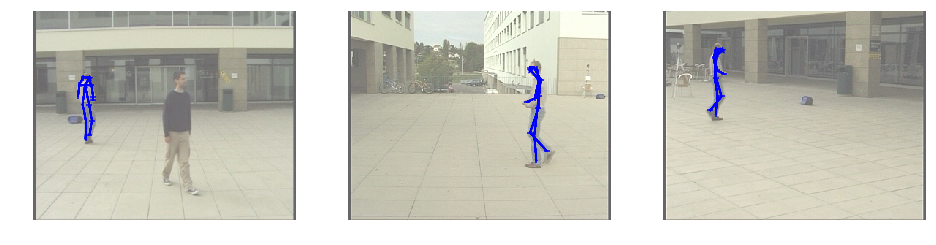

In [4]:
# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human
from mvpose.evaluation import pcp
import mvpose.data.kth_football2 as kth

Im, Y, Calib = epfl_campus.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)

#param = get_settings(scale_to_mm=1000)
param = get_settings(
    scale_to_mm=1000,
    ms_radius=50,
    ms_between_distance=50,
    ms_sigma=10,
    gc_iota_scale=0
)


Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

Humans = detections

# ===========================================
# find best PCP score
print('\n~~~~~~~~~~~PCP~~~~~~~~~~~~~~')
alpha = 0.5
HumansPCP = kth.transform3d_from_mscoco(Humans)
for gtid, gt in enumerate(Y):
    if gt is None:
        continue

    larms = 0
    uarms = 0
    llegs = 0
    ulegs = 0
    avg = 0
    for d in HumansPCP:
        r = pcp.evaluate(gt, d, alpha)
        larms_ = r.lower_arms
        uarms_ = r.upper_arms
        ulegs_ = r.upper_legs
        llegs_ = r.lower_legs
        avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
        if avg_ > avg:
            avg = avg_
            larms = larms_
            uarms = uarms_
            llegs = llegs_
            ulegs = ulegs_
            best_gtid = gtid
    
    print('pid=', gtid)
    print('\tlarms=', larms)
    print('\tuarms=', uarms)
    print('\tllegs=', llegs)
    print('\tulegs=', ulegs)
    print('\tavg=', avg)

    
# ===========================================

fig = plt.figure(figsize=(16,16))

colors = ['blue', 'yellow', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.show()

In [5]:
im.shape

(288, 360, 3)

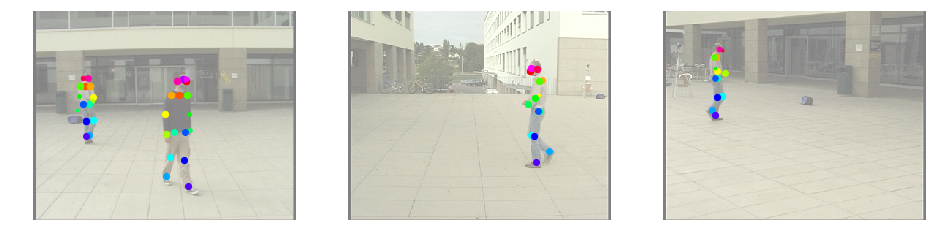

In [6]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.show()

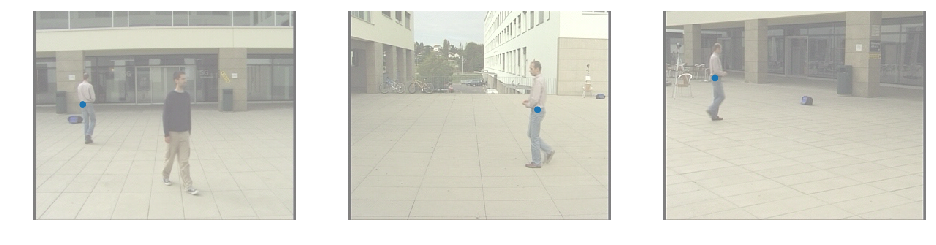

In [7]:
import mvpose.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
plt.show()

In [8]:
for human in Humans:
    n_valid_j = 0
    for joint in human:
        if joint is not None:
            n_valid_j += 1
        
    print('valid joints:', n_valid_j)

valid joints: 16


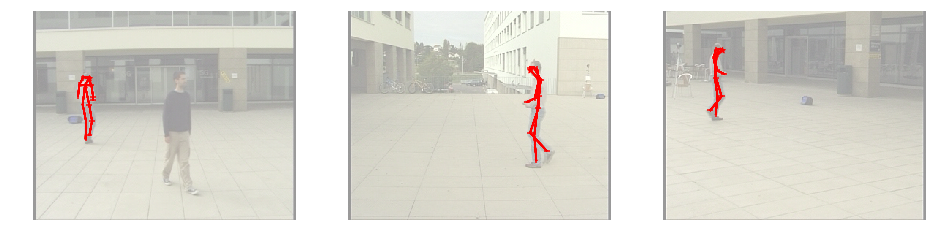

In [9]:
from mvpose.algorithm.candidate_selection import project_human_to_2d

#Humans = Debug.graphcut.person_candidates
Humans = Debug.candidate_selector.Surviving_Candidates


fig = plt.figure(figsize=(16,12))

colors = cs.lincolor(len(Humans) + 2) / 255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()